In [8]:
import pandas as pd
import numpy as np
import random
from random import choice

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, Bidirectional, Dropout, Dense, LayerNormalization, Add, BatchNormalization
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW

# 再現性確保
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# ファイル読み込み
df = pd.read_csv("../datasets/ring_data.csv")

# --- ラグ特徴 ---
df['体温_lag1'] = df['体温'].shift(1)
df['室温_lag1'] = df['室温'].shift(1)

# --- 差分特徴量（デルタ温度）---
df['delta_temp'] = df['室温'] - df['体温']
df['delta_temp_lag1'] = df['室温_lag1'] - df['体温_lag1']

# --- 移動平均・移動分散（ウィンドウサイズ3）---
window_size = 3
df['体温_ma3'] = df['体温'].rolling(window=window_size).mean()
df['体温_var3'] = df['体温'].rolling(window=window_size).var()
df['室温_ma3'] = df['室温'].rolling(window=window_size).mean()
df['室温_var3'] = df['室温'].rolling(window=window_size).var()

# 欠損値削除（shiftやrollingでできたNaNを削除）
df.dropna(inplace=True)

# 特徴量を拡充
features = [
    '体温', '体温_lag1',  '体温_ma3', '体温_var3', 
    '室温', '室温_lag1',  '室温_ma3', '室温_var3', 
    'delta_temp', 'delta_temp_lag1',  'アンケート'

]
target = '適温'

# 特徴量とターゲットを分離
X_raw = df[features].values
y_raw = df[[target]].values

# --- データ拡張（ノイズ付加） ---
noise_std = 0.01 * np.std(X_raw, axis=0)  # 1%のばらつきのノイズ
noise = np.random.normal(loc=0.0, scale=noise_std, size=X_raw.shape)
X_aug = X_raw + noise
y_aug = y_raw.copy()

# 元データと拡張データを結合
X_combined = np.vstack([X_raw, X_aug])
y_combined = np.vstack([y_raw, y_aug])


print("元データ数:", X_raw.shape[0])
print("拡張後データ数:", X_combined.shape[0])


# 正規化
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X_raw)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_raw)

# 時系列データ生成関数
def create_sequences(X, y, time_steps=3):
    n_samples = len(X) - time_steps
    X_seq = np.array([X[i:i+time_steps] for i in range(n_samples)])
    y_seq = y[time_steps:]
    return X_seq, y_seq

# シーケンス生成
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps = 3)
# 結果の形状確認
print(f"Input shape: {X_seq.shape}, Target shape: {y_seq.shape}")

# データのシャッフルとトレーニングデータとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False, random_state=42)

# ハイパーパラメータの範囲
epochs_list = [60,90,120]
batch_sizes = [4, 8, 16]
lstm_units = [60,90,120]
dropout_rates = [0.001,0.01,0.05]
l2_reg_strengths = [0.01,0.1,0.2]
best_loss = float('inf')
best_params = None
best_model = None

for _ in range(15):
    epochs = choice(epochs_list)
    batch_size = choice(batch_sizes)
    units = choice(lstm_units)
    dropout = choice(dropout_rates)
    l2_reg_strength = choice(l2_reg_strengths)

    print(f"Training with Epochs: {epochs}, Batch Size: {batch_size}, Units: {units}, Dropout: {dropout}, L2: {l2_reg_strength}")

    # --- モデル構築 ---
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # 双方向LSTM（1層目）
    x = Bidirectional(LSTM(units, return_sequences=True, kernel_regularizer=l2(l2_reg_strength)))(input_layer)
    x = LayerNormalization()(x)

    # 双方向LSTM（2層目）
    x = Bidirectional(LSTM(units // 2, return_sequences=False, kernel_regularizer=l2(l2_reg_strength)))(x)
    x = LayerNormalization()(x)

    residual = x
    residual_units = K.int_shape(residual)[-1]  # 静的にユニット数を取得
    x = Dense(residual_units, activation='gelu', kernel_regularizer=l2(l2_reg_strength))(x)
    x = Add()([x, residual])
    x = LayerNormalization()(x)
    x = Dropout(dropout)(x)

    # 最終出力
    output = Dense(1)(x)

    # モデル定義
    model = Model(inputs=input_layer, outputs=output)

    # コンパイル（AdamW）
    model.compile(optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), loss='mse')

    # コールバック
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # 学習
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    val_loss = history.history['val_loss'][-1]
    print(f"Validation Loss: {val_loss}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = (epochs, batch_size, units, dropout, l2_reg_strength)
        best_model = model
        best_history = history

print(f"Best Params: {best_params}")
print(f"Best Val Loss: {best_loss}")

元データ数: 382
拡張後データ数: 764
Input shape: (379, 3, 11), Target shape: (379, 1)
Training with Epochs: 120, Batch Size: 4, Units: 60, Dropout: 0.05, L2: 0.1

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 51: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Validation Loss: 0.004282915964722633
Training with Epochs: 60, Batch Size: 16, Units: 120, Dropout: 0.05, L2: 0.2
Validation Loss: 0.015314282849431038
Training with Epochs: 90, Batch Size: 4, Units: 90, Dropout: 0.01, L2: 0.2

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step
Mean Squared Error (MSE): 0.1000
Root Mean Squared Error (RMSE): 0.3162
Mean Absolute Error (MAE): 0.2429
R^2 Score: 0.8695
Test MSE: 0.1000
Test RMSE: 0.3162
Test MAE: 0.2429
Test R^2 Score: 0.8695


C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 12509 (\N{KATAKANA LETTER PO}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:40: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) Arial

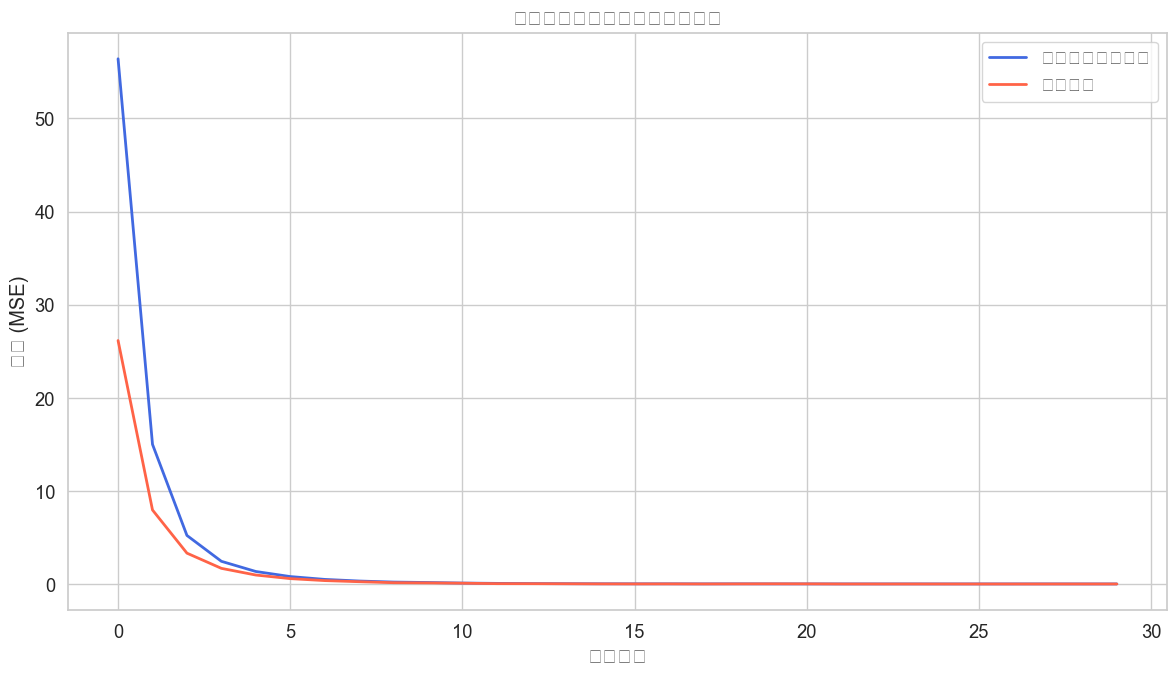

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 26178 (\N{CJK UNIFIED IDEOGRAPH-6642}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 12486 (\N{KATAKANA LETTER TE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\bsksh\AppData\Local\Temp\ipykernel_18580\1310692220.py:60: UserWarning: Glyph 12503 (\N{KATAKANA LETTER PU}) missing from font(s) Aria

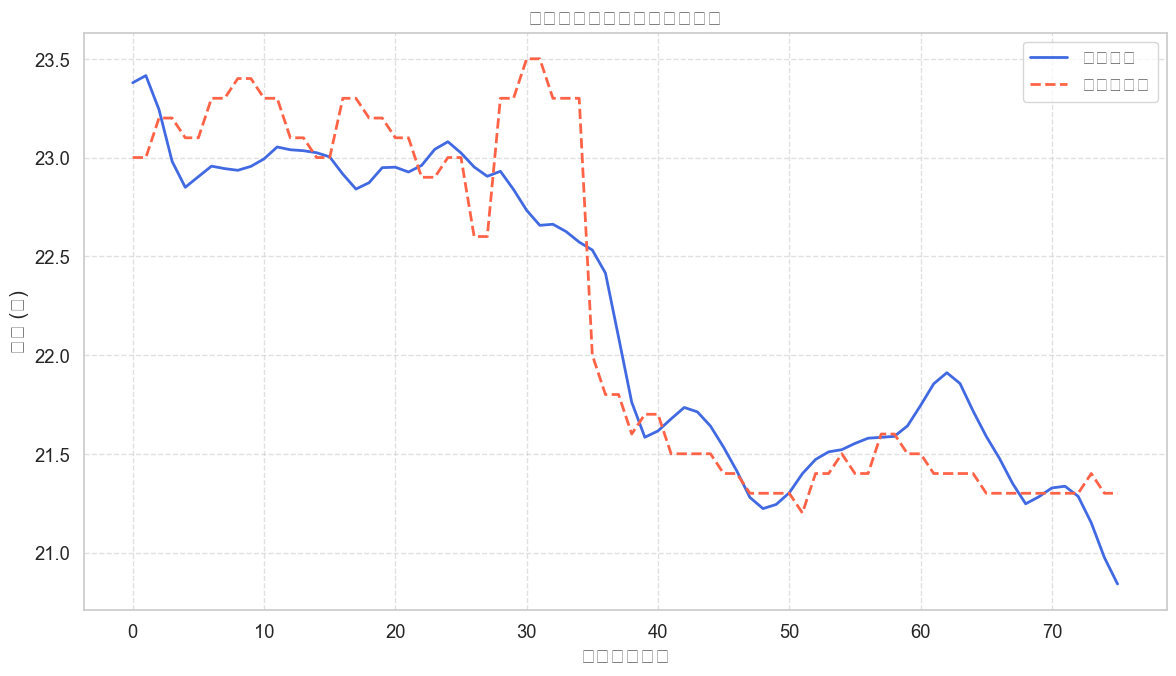

In [7]:
# ベストモデルで予測
predictions = best_model.predict(X_test)

# 逆正規化
predicted_temps = target_scaler.inverse_transform(predictions).flatten()
actual_temps = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 精度指標計算
mse = mean_squared_error(actual_temps, predicted_temps)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_temps, predicted_temps)
r2 = r2_score(actual_temps, predicted_temps)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R^2 Score: {r2:.4f}")

# 精度指標計算
mse = mean_squared_error(actual_temps, predicted_temps)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_temps, predicted_temps)
r2 = r2_score(actual_temps, predicted_temps)
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

# seabornスタイル設定
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# 予測と実際の適温比較グラフ（損失推移）
plt.figure(figsize=(12, 7))
sns.lineplot(data=best_history.history['loss'], label='トレーニング損失', color='royalblue', linewidth=2)
sns.lineplot(data=best_history.history['val_loss'], label='検証損失', color='tomato', linewidth=2)
plt.title('トレーニングと検証の損失推移')
plt.xlabel('エポック')
plt.ylabel('損失 (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

# ベストモデルで予測
predictions = best_model.predict(X_test)

# 逆正規化
predicted_temps = target_scaler.inverse_transform(predictions).flatten()
actual_temps = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


# 逆正規化後の予測と実測の適温推移グラフ
plt.figure(figsize=(12, 7))
sns.lineplot(x=range(len(predicted_temps)), y=predicted_temps, label='予測適温', color='royalblue', linewidth=2)
sns.lineplot(x=range(len(actual_temps)), y=actual_temps, label='実際の適温', color='tomato', linestyle='--', linewidth=2)
plt.title('予測適温と実際の適温の比較')
plt.xlabel('時間ステップ')
plt.ylabel('温度 (℃)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import os


# 評価指標を辞書でまとめる
results_dict = {
    "MSE": [mse],
    "RMSE": [rmse],
    "MAE": [mae],
    "R2": [r2]
}

# DataFrameに変換
results_df = pd.DataFrame(results_dict)

# 保存先ディレクトリ
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)  # フォルダがなければ作成

# 保存ファイル名
filename = "ring_lstm.csv"  

# フルパスを作成
filepath = os.path.join(results_dir, filename)

# CSV保存（indexは不要）
results_df.to_csv(filepath, index=False)

print(f"評価結果を保存しました: {filepath}")
